## RNN chat generator

In [53]:
import re
import glob
import os
import numpy as np

import nltk
nltk.download('punkt')

from nltk import word_tokenize
from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
ChineseFont = FontProperties(fname='C:\\Windows\\Fonts\\simsun.ttc')

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\issohl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Import

https://childes.talkbank.org/access/Biling/Singapore.html

In [3]:
text = []

def extract_text(lines):
    # conversations start with something like this:
    # *TIF:\tsomething

    # strip out anything within square brackets
    filtered = [re.sub(r'\[.*\]', '' , l) for l in lines if l.startswith('*')]
    
    # strip out speaker
    filtered = [re.sub(r'\*(.*):\t', '' , l) for l in filtered]

    # replace some characters with space
    filtered = [re.sub(r'[_]', ' ' , l) for l in filtered]

    # remove some characters
    filtered = [re.sub(r'[#@\(\)&?!.,;:<>]', '' , l) for l in filtered]
    
    return filtered

for filename in glob.iglob('Singapore/*.cha', recursive=True):
    # print(filename)
    lines = open(filename, encoding='utf-8', errors='ignore').read().split('\n')
    text += extract_text(lines)
    
print('raw text count:', len(text))

raw text count: 43734


## Train Word2Vec

In [6]:
tokens = []
for l in text:
    candidates = [t.lower() for t in word_tokenize(l) if len(t) > 0]
    if len(candidates) > 0:
        tokens.append(candidates)

In [7]:
vector_size=20
window_size=5

# train
word2vec = Word2Vec(tokens, size=vector_size, window=window_size,
                    min_count=1, workers=4)

word2vec.wv.vocab

{'www': <gensim.models.keyedvectors.Vocab at 0x16924d1be80>,
 'yyy': <gensim.models.keyedvectors.Vocab at 0x16924d1d240>,
 'xxx': <gensim.models.keyedvectors.Vocab at 0x16924d1d198>,
 'lea': <gensim.models.keyedvectors.Vocab at 0x16924d1d128>,
 'you': <gensim.models.keyedvectors.Vocab at 0x16924d1d160>,
 'go': <gensim.models.keyedvectors.Vocab at 0x16924d1d208>,
 'to': <gensim.models.keyedvectors.Vocab at 0x16924d1d278>,
 'your': <gensim.models.keyedvectors.Vocab at 0x16924d1d2b0>,
 'car': <gensim.models.keyedvectors.Vocab at 0x16924d1d2e8>,
 'race': <gensim.models.keyedvectors.Vocab at 0x16924d1d320>,
 'then': <gensim.models.keyedvectors.Vocab at 0x16924d1d358>,
 'let': <gensim.models.keyedvectors.Vocab at 0x16924d1d390>,
 'arm': <gensim.models.keyedvectors.Vocab at 0x16924d1d3c8>,
 'straight': <gensim.models.keyedvectors.Vocab at 0x16924d1d400>,
 'i': <gensim.models.keyedvectors.Vocab at 0x16924d1d438>,
 'legoland': <gensim.models.keyedvectors.Vocab at 0x16924d1d470>,
 'in': <gensim.

In [8]:
test = '好了'
word2vec.wv[test]

array([ 0.66575986,  0.7628555 , -0.7540279 , -0.6638137 ,  0.5878297 ,
        0.07946228, -0.32449135, -0.30493426, -0.7871192 , -0.03800163,
        0.44533968, -0.2454225 ,  0.05542471, -0.22505334,  0.07526637,
       -0.88719076, -0.5103141 , -0.04164277,  0.18903337, -0.19199304],
      dtype=float32)

In [9]:
word2vec.most_similar(test)

C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('回', 0.9990689158439636),
 ('比较', 0.9990443587303162),
 ('对吗', 0.999019205570221),
 ('收', 0.9989565014839172),
 ('快', 0.9988330602645874),
 ('她', 0.9987597465515137),
 ('小朋友', 0.9986642003059387),
 ('打', 0.9986463785171509),
 ('呀i', 0.9986446499824524),
 ('才', 0.9985874891281128)]

In [10]:
test = 'lor'
word2vec.most_similar(test)

C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('once', 0.985925018787384),
 ('泰霖', 0.9835164546966553),
 ('rude', 0.9814838171005249),
 ('runs', 0.9800387620925903),
 ('tickle', 0.9799298048019409),
 ('each', 0.9798858761787415),
 ('noone', 0.979499340057373),
 ('kill', 0.978962242603302),
 ('bed', 0.9789350032806396),
 ('hurry', 0.9782980680465698)]

In [11]:
# plot the vectors in vector space
pca = PCA(n_components=2)
wv_2d = pca.fit_transform(word2vec.wv.vectors)

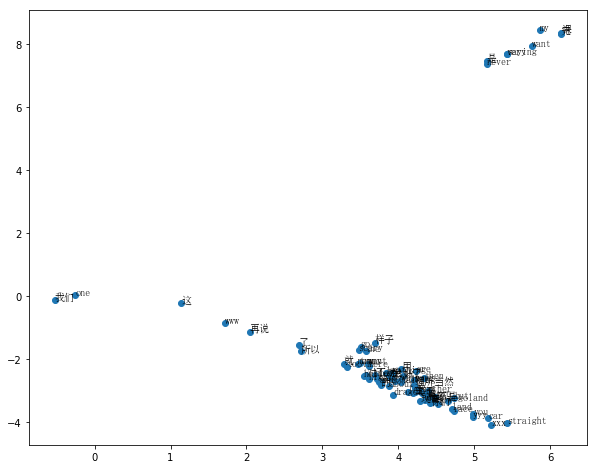

In [12]:
limit = 75

fig, ax = plt.subplots(figsize=(10, 8))
vocab = list(word2vec.wv.vocab.keys())

ax.scatter(wv_2d[:limit, 0], wv_2d[:limit, 1])

for i in range(limit):
    ax.annotate(vocab[i], (wv_2d[i, 0], wv_2d[i, 1]), fontproperties=ChineseFont)

In [20]:
def word_to_index(token):
    return word2vec.wv.vocab[token].index

def index_to_word(index):
    return word2vec.wv.index2word[index]

def sequence_to_indices(sequence):
    return np.array([word_to_index(t) for t in sequence])

def indices_to_sequence(indices):
    return np.array([index_to_word(i) for i in indices])

print(word_to_index('hello'))
print(index_to_word(word_to_index('hello')))

133
hello


# RNN

- We have raw sentences and need to convert to X, y. 
- X will be sequence_length, and y will be the next word in the sequence
- For each word, we need to convert to its word2vec index. This will be used later on by the Embedding layer (which will contain the vectors).

In [28]:
sequence_len = 3

X = []
y = []

for seq in tokens:
    if len(seq) > sequence_len:
        # Replace with word2vec indices
        token_indices = sequence_to_indices(seq)

        for i in range(len(seq)-sequence_len):          
            X.append(token_indices[i:i+sequence_len])
            y.append(token_indices[i+sequence_len])
            
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)
print(indices_to_sequence(X[0]), X[0], index_to_word(y[0]), y[0])

(91495, 3) (91495,)
['xxx' 'lea' 'you'] [  0 253   2] go 35


In [55]:
vocab_size = len(word2vec.wv.vocab)

y_cat = to_categorical(y, vocab_size)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat)
print(y_train[0])

[0. 0. 0. ... 0. 0. 0.]


In [56]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

print('vocab size', vocab_size)
print('embedding size', word2vec.wv.vector_size)
print('sequence length', sequence_len)

model = Sequential()
model.add(Embedding(vocab_size, word2vec.wv.vector_size,
                    input_length=sequence_len,
                    weights=[word2vec.wv.vectors]))
model.add(LSTM(20))
model.add(Dense(vocab_size, activation='softmax'))
model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

vocab size 6103
embedding size 20
sequence length 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 3, 20)             122060    
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_6 (Dense)              (None, 6103)              128163    
Total params: 253,503
Trainable params: 253,503
Non-trainable params: 0
_________________________________________________________________


In [57]:
import time
es = EarlyStopping(patience=2)
mc = ModelCheckpoint('rnn_singlish.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True)
tb = TensorBoard(log_dir='./logs/rnn_singlish/{}'.format(int(time.time())))

model.fit(X_train, y_train, batch_size=128, epochs=30, validation_split=0.25)

Train on 51465 samples, validate on 17156 samples
Epoch 1/30
51465/51465 [==============================] - 28s 554us/step - loss: 6.6979 - acc: 0.0510 - val_loss: 6.2871 - val_acc: 0.0546
Epoch 2/30
51465/51465 [==============================] - 26s 498us/step - loss: 6.1084 - acc: 0.0570 - val_loss: 6.1169 - val_acc: 0.0565
Epoch 3/30
51465/51465 [==============================] - 24s 471us/step - loss: 5.9472 - acc: 0.0637 - val_loss: 5.9794 - val_acc: 0.0701
Epoch 4/30
51465/51465 [==============================] - 26s 506us/step - loss: 5.8048 - acc: 0.0763 - val_loss: 5.8593 - val_acc: 0.0873
Epoch 5/30
51465/51465 [==============================] - 29s 562us/step - loss: 5.6844 - acc: 0.0967 - val_loss: 5.7590 - val_acc: 0.0986
Epoch 6/30
51465/51465 [==============================] - 28s 547us/step - loss: 5.5782 - acc: 0.1083 - val_loss: 5.6677 - val_acc: 0.1081
Epoch 7/30
51465/51465 [==============================] - 26s 513us/step - loss: 5.5011 - acc: 0.1155 - val_loss: 5.